In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'
fn_random_start = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)
data_rnd = pd.read_csv(fn_random_start)

In [4]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
data_rnd, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data_rnd)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:69: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarni

In [5]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
# interaction = 'energies'
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)
dfm_rnd = melt(data_rnd[data_rnd['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)

# dfm = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(
#     data, interaction), var_name='idx', value_name=interaction)

/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:120: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols2(info, k)].apply(
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:122: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>

### The problem

<AxesSubplot: xlabel='sensitivity_wrt_species-6', ylabel='Count'>

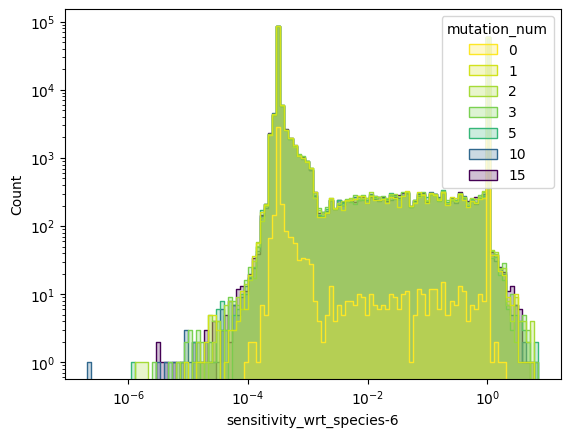

In [6]:
sns.histplot(data_rnd, x='sensitivity_wrt_species-6', hue='mutation_num', element='step', log_scale=[True, True], palette='viridis_r')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'CDF of Sensitivity - Unbiased reference circuits\nNot including RNA_0')

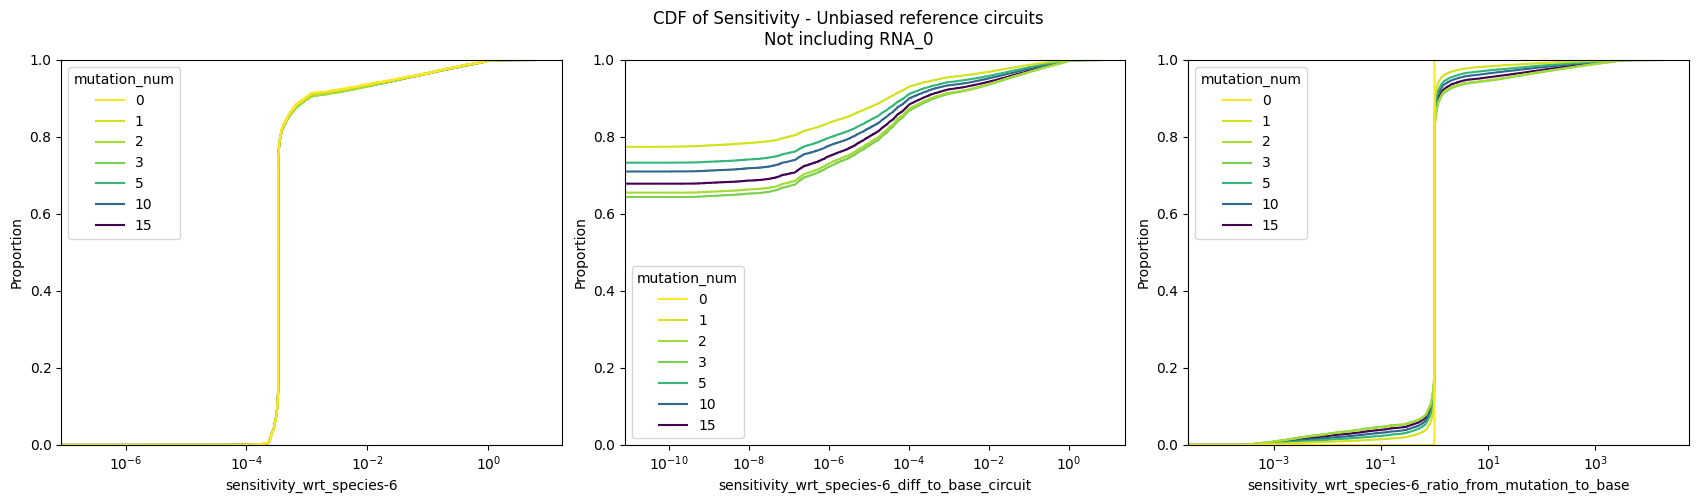

In [7]:

fig = plt.figure(figsize=(21, 5))
fig.subplots_adjust(hspace=0.125, wspace=0.125)

ax = plt.subplot(1,3,1)
sns.ecdfplot(data_rnd[data_rnd['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, False], palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.ecdfplot(data_rnd[data_rnd['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6_diff_to_base_circuit', hue='mutation_num', log_scale=[True, False], palette='viridis_r')
ax = plt.subplot(1,3,3)
sns.ecdfplot(data_rnd[data_rnd['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', hue='mutation_num', log_scale=[True, False], palette='viridis_r')

plt.suptitle('CDF of Sensitivity - Unbiased reference circuits\nNot including RNA_0')

<AxesSubplot: xlabel='binding_rates_dissociation', ylabel='Count'>

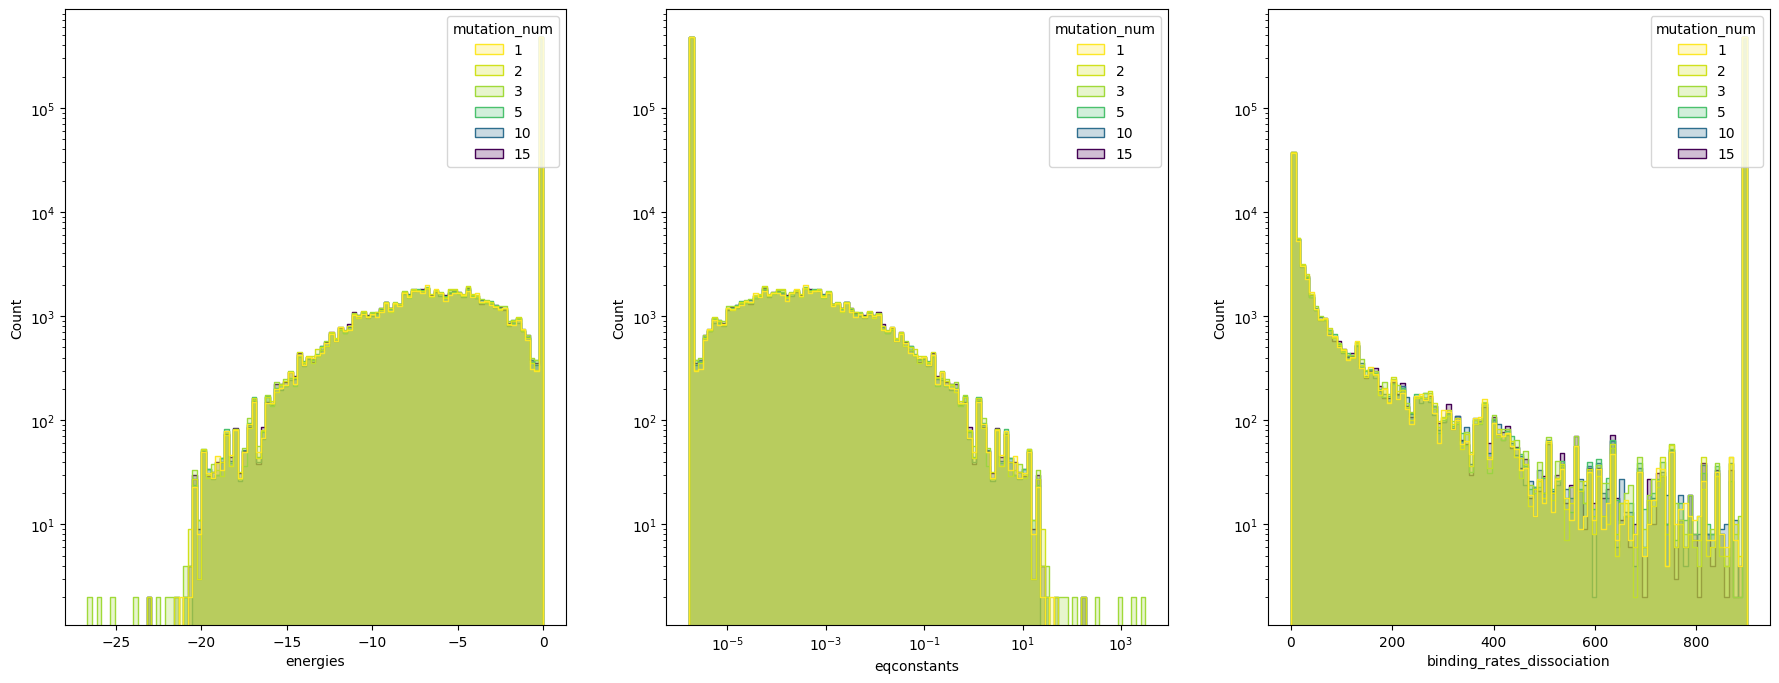

In [8]:

plt.figure(figsize=(22, 8))
ax = plt.subplot(1,3,1)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] > 0], x='energies', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] > 0], x='eqconstants', hue='mutation_num', log_scale=[True, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,3)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] > 0], x='binding_rates_dissociation', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')


### Investigate gain of interaction mutations

For some reason there's a weird ranking in the mutation numbers

In [9]:
low_circs = dfm[(dfm['num_interacting'] == 2) & (dfm['num_self_interacting'] == 1) & (dfm['mutation_num'] == 0)]['circuit_name'].unique()

gain_dfm = dfm[dfm['circuit_name'].isin(low_circs) & (dfm['mutation_num'] > 0) & (dfm['num_interacting'] >= 2) & (dfm['num_self_interacting'] >= 1)]

Text(0.5, 1.0, 'Unbiased reference circuits')

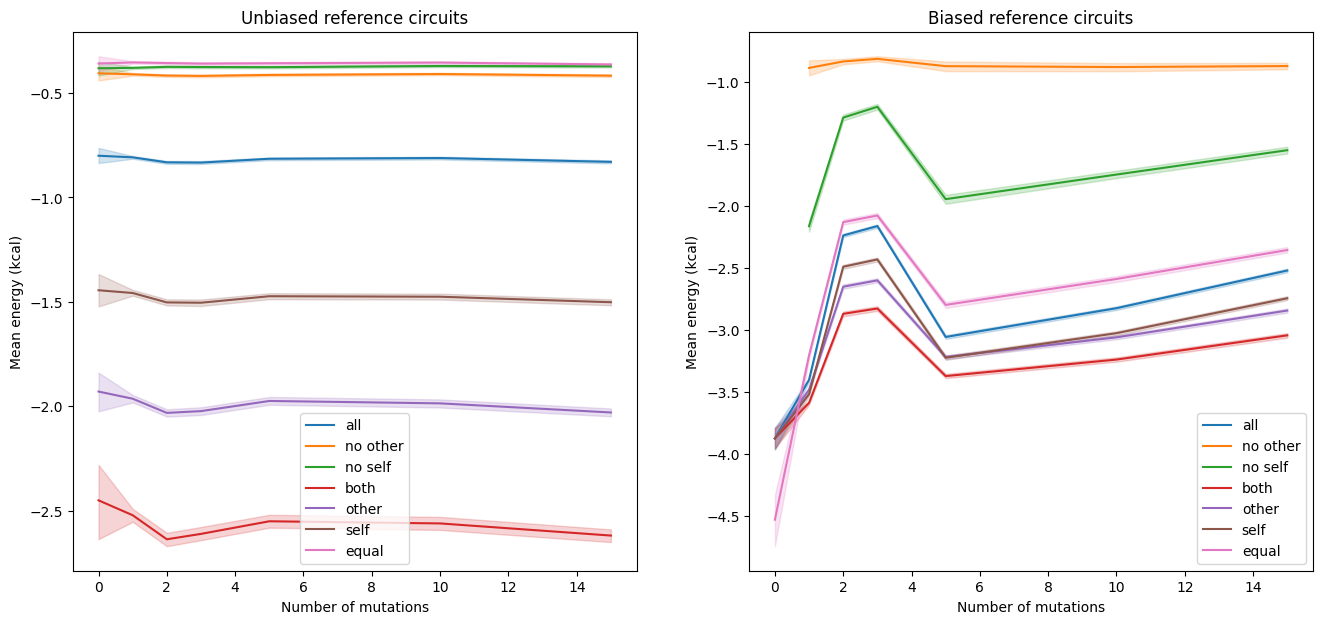

In [10]:
m = dfm # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm[dfm['num_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm[dfm['num_self_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0)] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm[dfm['num_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm[dfm['num_self_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm[dfm['num_self_interacting'] == dfm['num_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,2)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')
plt.title('Biased reference circuits')


m = dfm_rnd # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm_rnd[dfm_rnd['num_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm_rnd[dfm_rnd['num_self_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm_rnd[(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm_rnd[dfm_rnd['num_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm_rnd[dfm_rnd['num_self_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm_rnd[dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')
plt.title('Unbiased reference circuits')

Text(0.5, 1.0, 'm_equal, total: 1746918')

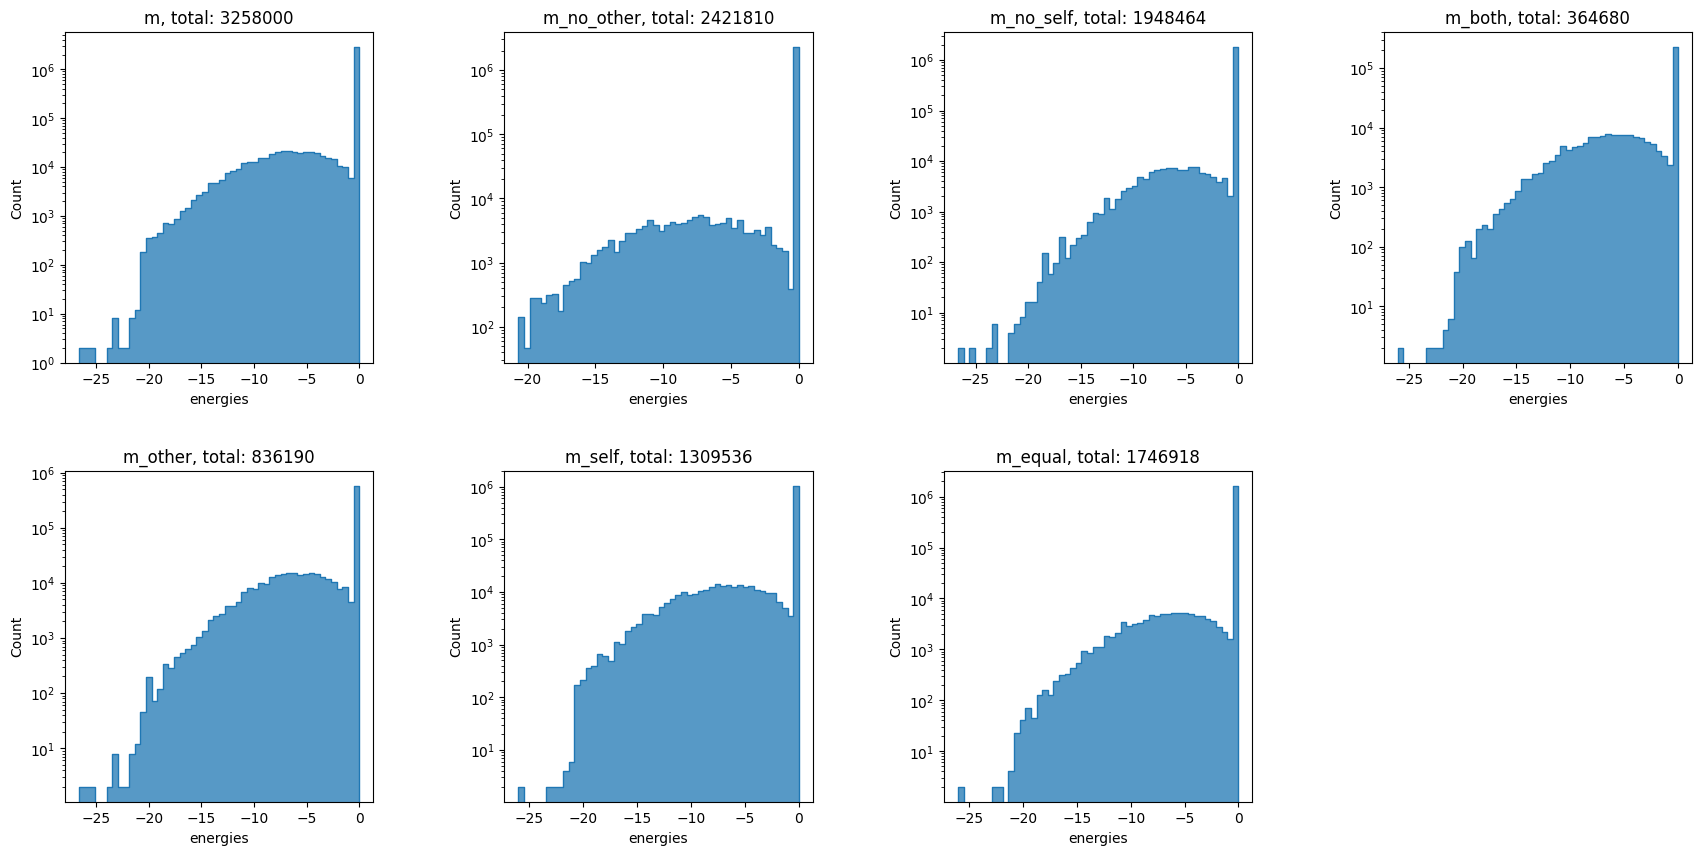

In [11]:
fig = plt.figure(figsize=(21, 10))
fig.subplots_adjust(hspace=0.325, wspace=0.425)

i = 1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd, x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m' + ', total: ' + str(len(dfm_rnd)))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['num_interacting'] == 0], x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m_no_other' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_interacting'] == 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['num_self_interacting'] == 0], x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m_no_self' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_self_interacting'] == 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)], x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m_both' + ', total: ' + str(len(dfm_rnd[(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['num_interacting'] > 0], x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m_other' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_interacting'] > 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['num_self_interacting'] > 0], x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m_self' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_self_interacting'] > 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']], x='energies', log_scale=[False, True], element='step', bins=50)
plt.title('m_equal' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']])))


Text(0.5, 0.98, 'Gain of interactions upon mutation: Biased starting circuits')

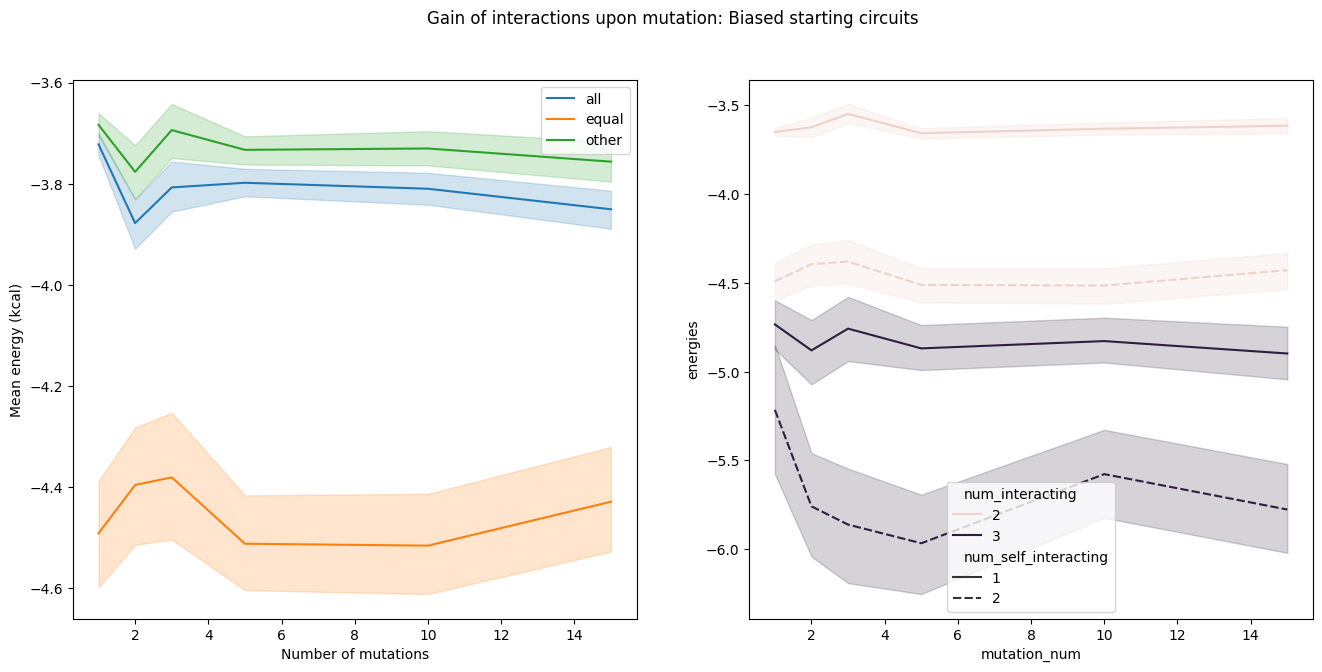

In [12]:
m = gain_dfm #.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = gain_dfm[gain_dfm['num_interacting'] == gain_dfm['num_self_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = gain_dfm[gain_dfm['num_interacting'] > gain_dfm['num_self_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = gain_dfm[gain_dfm['num_self_interacting'] > gain_dfm['num_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})


plt.figure(figsize=(16,7))
ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')

ax = plt.subplot(1,2,2)
# m = gain_dfm.groupby(['mutation_num', 'num_interacting', 'num_self_interacting'], as_index=False).agg({'energies': 'mean'})
sns.lineplot(m, x='mutation_num', y='energies', hue='num_interacting', style='num_self_interacting')

plt.suptitle('Gain of interactions upon mutation: Biased starting circuits')


Above, the mean interaction energies of circuits that have had a gain in interactions are plotted. A gain in interactions just means that a circuit that originally had a low number of interacting RNAs mutated and gained in the number of other/self-interacting species. 

In [13]:
dfm['bs_group_index'] = dfm['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs = dfm.explode(column=['num_bs', 'bs_group_index'])

dfm_rnd['bs_group_index'] = dfm_rnd['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs_rnd = dfm_rnd.explode(column=['num_bs', 'bs_group_index'])


Text(0.5, 0.98, 'Unbiased starting circuits')

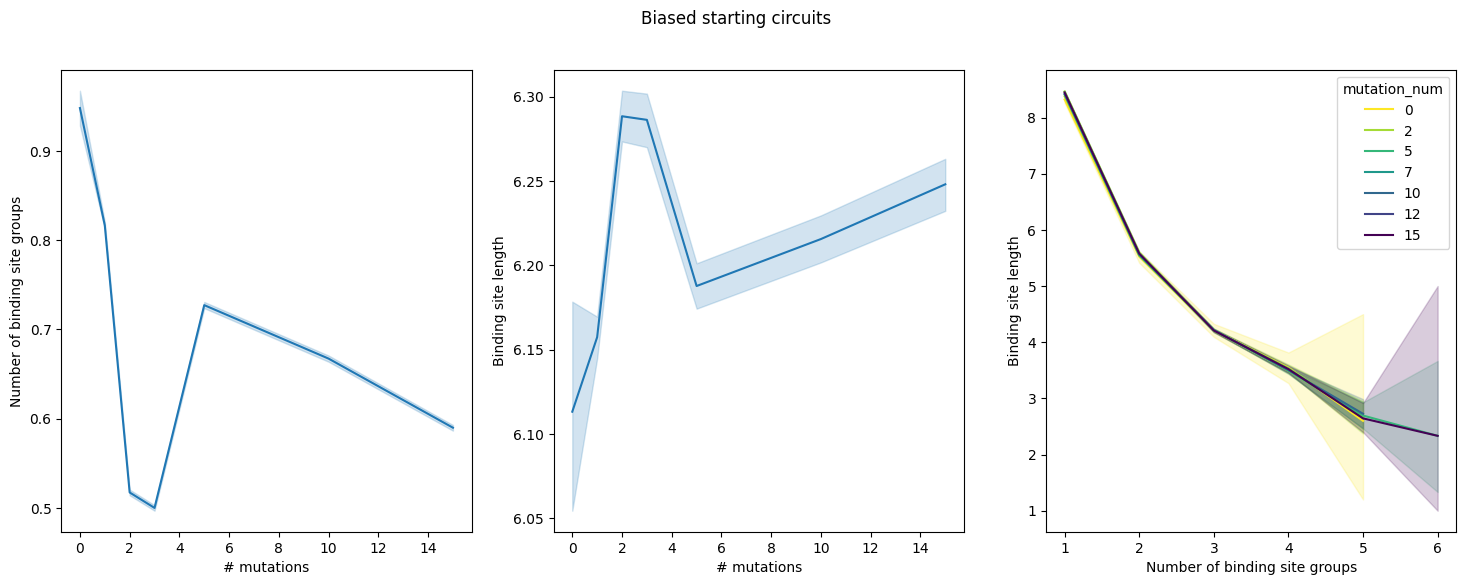

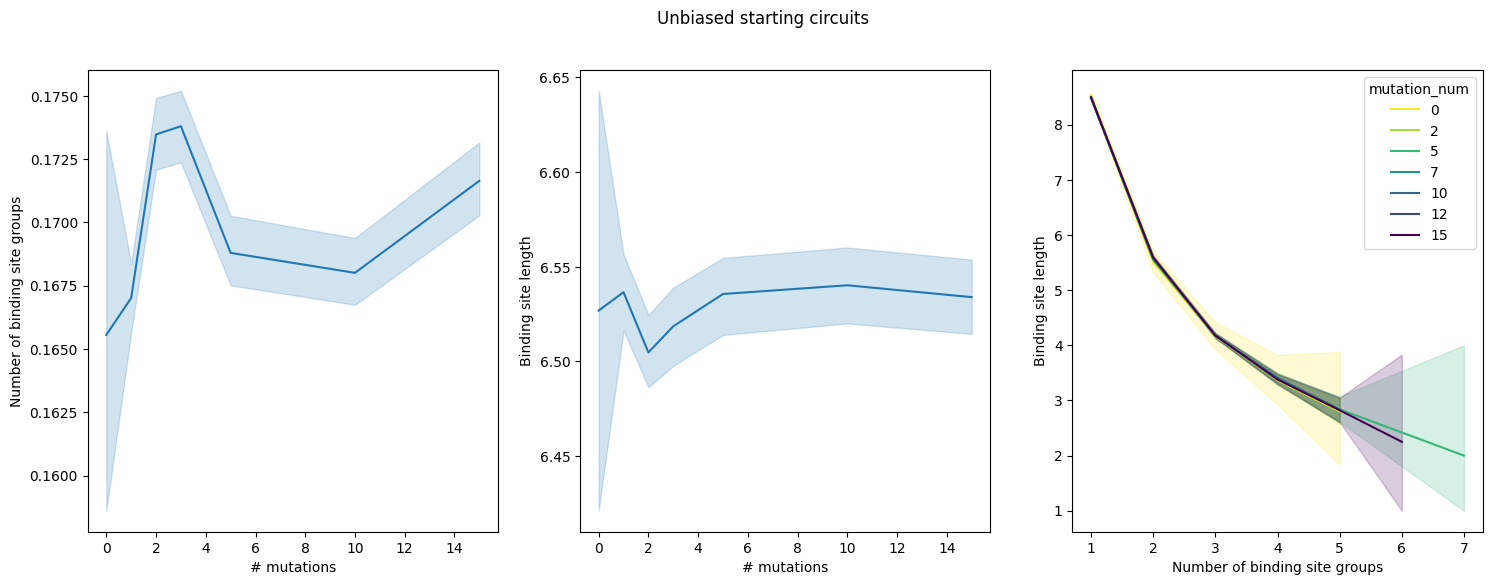

In [14]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')

plt.suptitle('Biased starting circuits')


plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm_rnd, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')

plt.suptitle('Unbiased starting circuits')




Text(0.5, 0.98, 'Unbiased starting circuits')

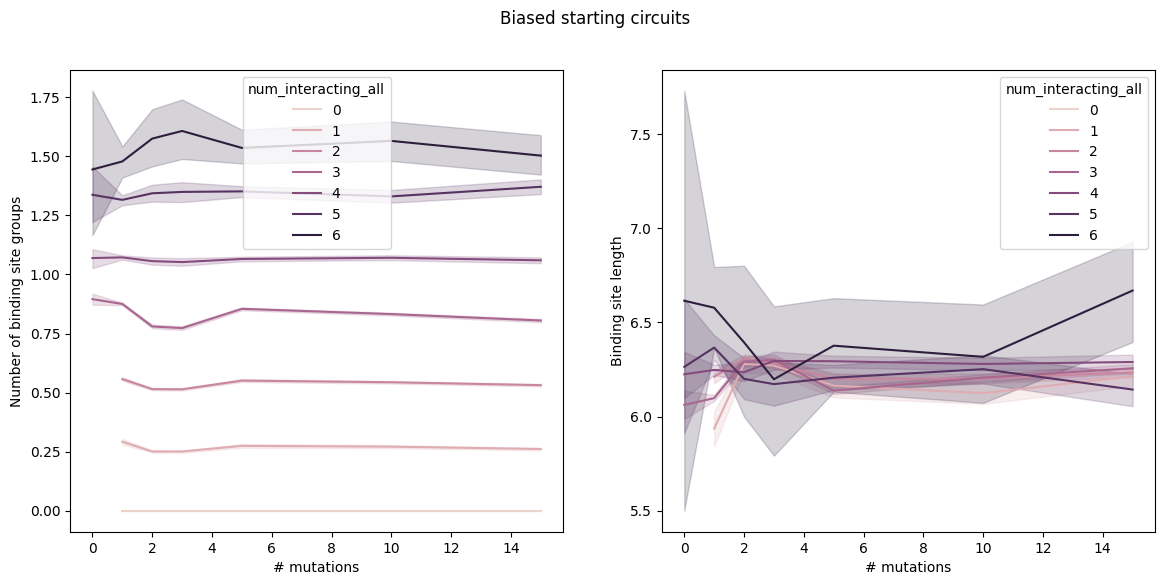

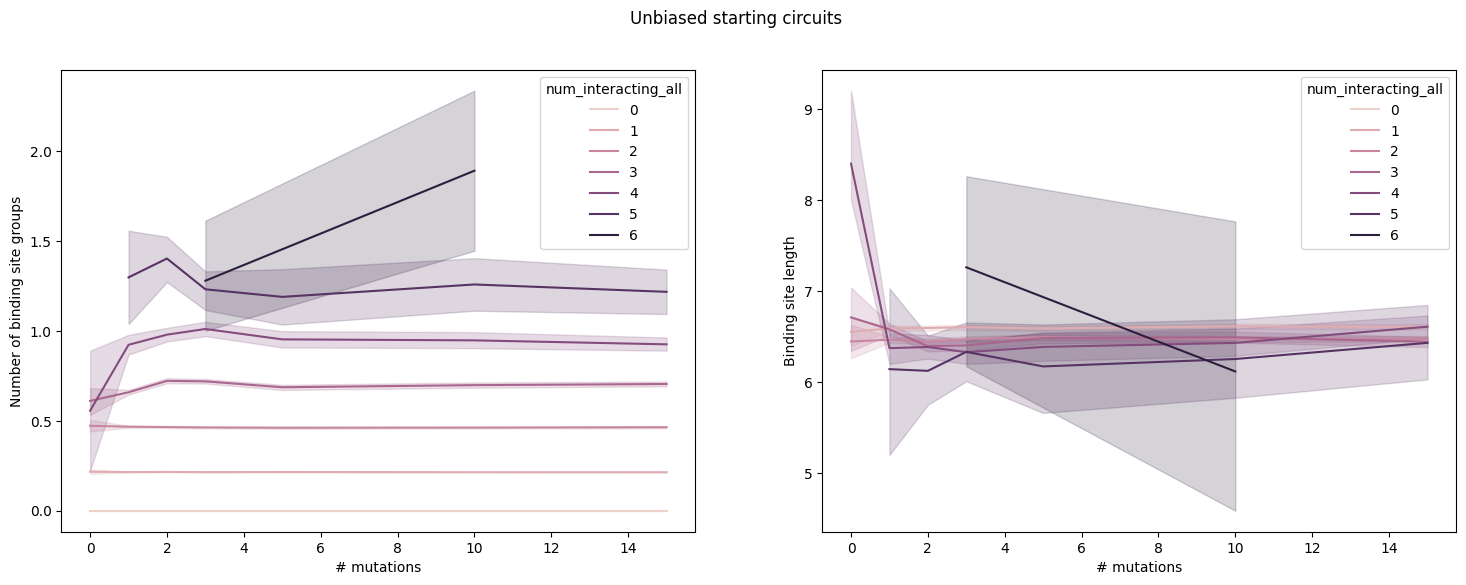

In [15]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm, x='mutation_num', y='num_groups', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs.reset_index(), x='mutation_num', y='num_bs', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

plt.suptitle('Biased starting circuits')


plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm_rnd, x='mutation_num', y='num_groups', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='mutation_num', y='num_bs', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

plt.suptitle('Unbiased starting circuits')


In [20]:
print('The biased circuits have the following sample numbers for each category of number of interacting species.')
dfm['num_interacting_all'].value_counts()

The biased circuits have the following sample numbers for each category of number of interacting species


2    571743
3    545499
1    266868
4    163791
0     54135
5     25236
6      1728
Name: num_interacting_all, dtype: int64

In [22]:
print('On the other hand, the unbiased circuits have the following sample numbers for each category of\n', 
      'number of interacting species, having much lower sample numbers as the number of interacting\n',
      'samples increases compared to the circuits that were chosen in a biased manner from the offest.')
dfm_rnd['num_interacting_all'].value_counts()

On the other hand, the unbiased circuits have the following sample numbers for each category of
 number of interacting species, having much lower sample numbers as the number of interacting
 samples increases compared to the circuits that were chosen in a biased manner from the offest.


0    1476954
1    1205640
2     463401
3      99711
4      11358
5        909
6         27
Name: num_interacting_all, dtype: int64

Text(0.5, 0, 'Binding site length')

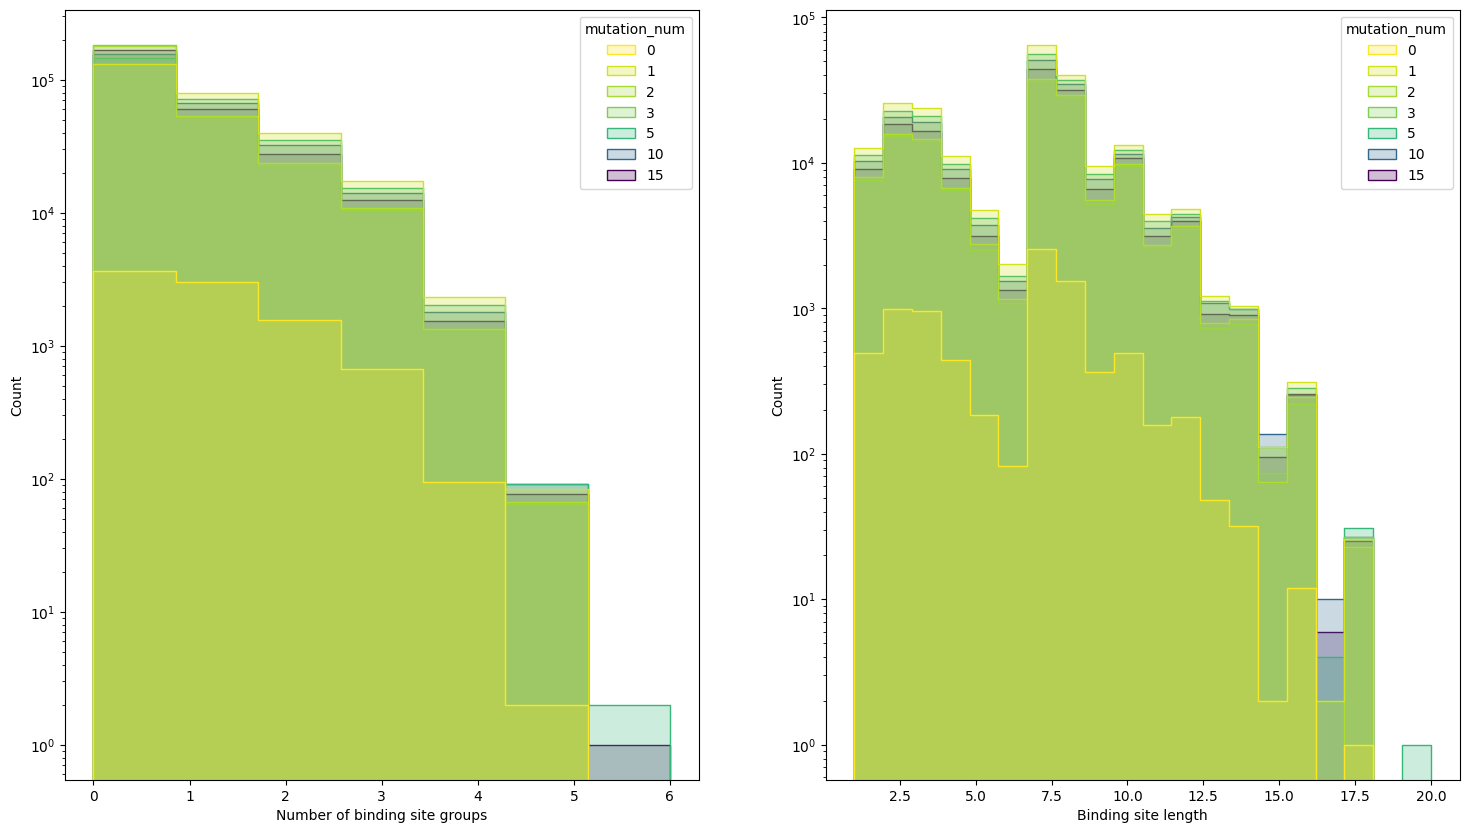

In [16]:
plt.figure(figsize=(18,10))
ax = plt.subplot(1,2,1)
sns.histplot(dfm, hue='mutation_num', x='num_groups', element='step', palette='viridis_r', bins = 7, log_scale=[False, True])
plt.xlabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.histplot(dfm_e_bs.reset_index(), hue='mutation_num', x='num_bs', palette='viridis_r', element='step', bins=20, log_scale=[False, True])
plt.xlabel('Binding site length')

Text(0, 0.5, 'Energies (kcal)')

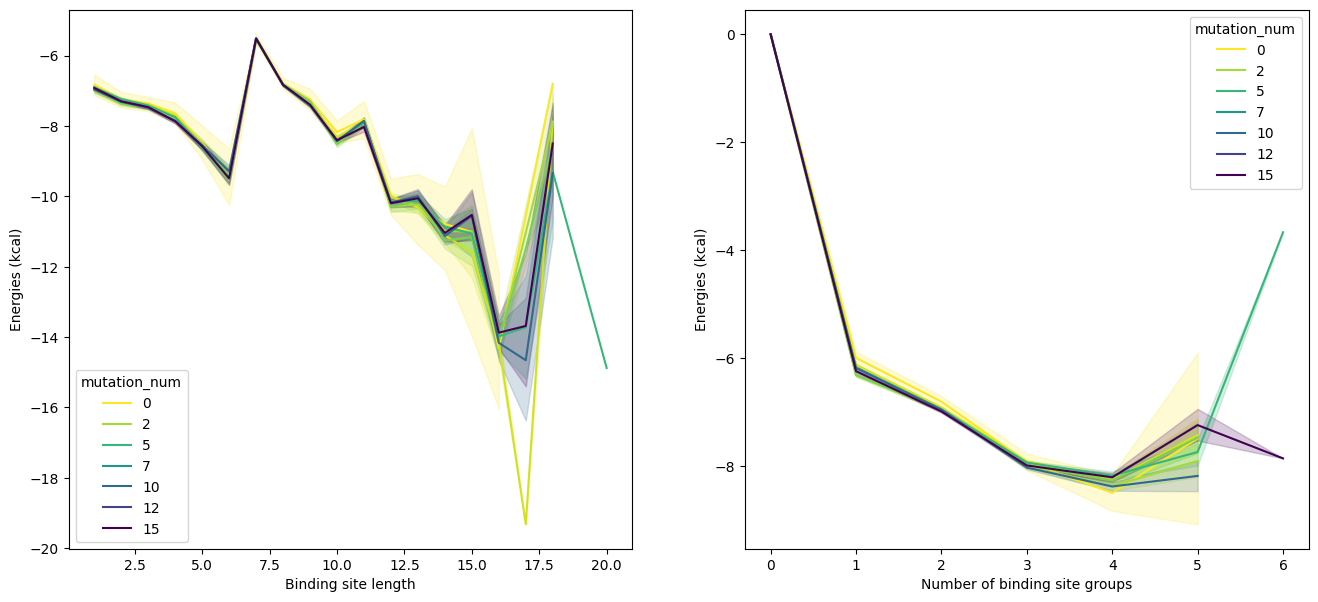

In [17]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm_e_bs.reset_index(), x='num_bs', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Binding site length')
plt.ylabel('Energies (kcal)')
ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Number of binding site groups')
plt.ylabel('Energies (kcal)')